In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style('onedork')
import colorsys
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import csv
import gc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import dill as pickle
import warnings
warnings.filterwarnings("ignore")

## Function to get data in a manner where memory can later be released
def getData(X_filename, y_filename, use_feats):
    ## First get the dimensions of the dataset
    with open (X_filename, 'r') as f:
        csvreader_X = csv.reader(f)
        rows = -1
        for j, line in enumerate(csvreader_X):
            if j == 0:
                if len(use_feats) == 0:
                    cols = len(line[1:])
                else:
                    cols = len(use_feats)
            rows += 1
    ## Then open the dataset 
    with open (X_filename, 'r') as f:
        csvreader_X = csv.reader(f)
        X_samps = []
        X_vals = np.ndarray((rows, cols), dtype = float)
        for j, line in enumerate(csvreader_X):
            if j == 0:
                temp_feats = np.array(line[1:])
                if len(use_feats) == 0:
                    X_feats = temp_feats
                    X_feats_inds = np.array(list(range(len(temp_feats))))
                else:
                    X_feats = use_feats
                    X_feats_inds = np.array([np.where(temp_feats == x)[0].tolist()[0] for x in use_feats])
            else:
                X_samps.append(line[0])
                X_vals[j-1,:] = np.array(line[1:])[X_feats_inds.tolist()].tolist()
        X_vals[X_vals == 0] = np.nan
        X_samps = np.array(X_samps)
    ## Import y
    y = pd.read_csv(y_filename, index_col = 0)
    del temp_feats, X_feats_inds, csvreader_X, j, line
    gc.collect()
    return X_vals, X_feats, X_samps, y

### Let's take a look at some of the data.

In [2]:
print('Importing data...')
## Import X and y data for micro RNAs
X_vals, X_feats, X_samps, y = getData('../data/new_mirna_X.csv', '../data/new_mirna_y.csv', [])
print('Done!')

Importing data...
Done!


### There are many null values as is common with large molecular datasets

In [3]:
X_vals[np.isnan(X_vals)] = 0
print(np.array([X_vals.shape[0]]*X_vals.shape[1]) - np.count_nonzero(X_vals, axis = 0))

[0 0 0 ..., 3 0 0]


### Let's find the effective dimensionality of the data.

Scaling data...
Getting principle components...
Explained variances of top components: [ 0.06415842  0.03194106  0.02626811  0.02052804  0.01354454  0.0126124
  0.00909827  0.00853966  0.00813168  0.00717104  0.00708172  0.00611055
  0.00570566  0.00539407  0.00523164  0.00516404  0.00463669  0.00427587
  0.00420726  0.00414889  0.00407939  0.00396536  0.00391217  0.00360977
  0.00357572  0.00337437  0.00324761  0.00300984  0.00296909  0.00289608
  0.00284993  0.00277276  0.00274246  0.00269058  0.00265228  0.00262841
  0.00250045  0.00247405  0.00238309  0.00233043  0.00230481  0.0022187
  0.00220401  0.00217711  0.00211377  0.00210325  0.00205387  0.00203899
  0.00199732  0.00197302  0.00193221  0.00192056  0.00188591  0.00186416
  0.00183675  0.00182517  0.00179954  0.00179736  0.00175515  0.00173916
  0.0017124   0.00170317  0.00169335  0.0016851   0.00165443  0.00164597
  0.00162769  0.00160897  0.00159256  0.0015778   0.00157162  0.00154572
  0.00153379  0.0015166   0.00150277  0

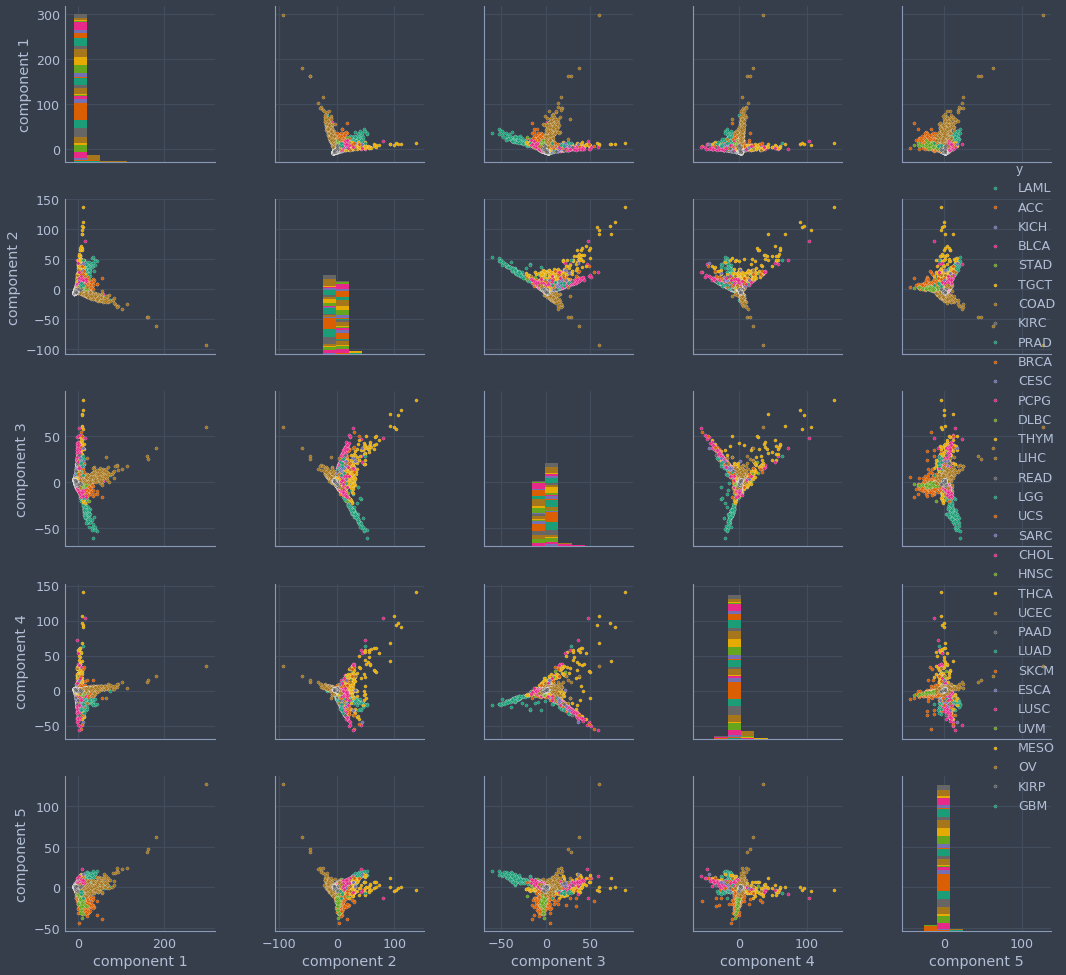

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

print('Scaling data...')
scl = StandardScaler()
X_scl = scl.fit_transform(X_vals, y)

del X_vals
gc.collect()

print('Getting principle components...')
n_components = 1000
pca = PCA(n_components = n_components)
X_pca = pca.fit_transform(X_scl, y)

## Explained variance for each component
print('Explained variances of top components:', pca.explained_variance_ratio_[:20])
sum_of_explained_variance = 0
n_components_needed_for_majority_variance = 0
for i, each in enumerate(pca.explained_variance_ratio_):
    sum_of_explained_variance += each
    if sum_of_explained_variance > 0.5:
        n_components_needed_for_majority_variance = i+1
        break
if n_components_needed_for_majority_variance > 0:
    print(n_components_needed_for_majority_variance, 'components explain the majority of the variance.')
else:
    print('100 components could only explain', sum_of_explained_variance*100, 'percent of the variance.')
## Make plots of decomposed and transformed data
sns.pairplot(pd.concat([pd.DataFrame(X_pca[:,0:5], index = X_samps, 
                                     columns = ['component 1', 'component 2', 'component 3', 'component 4', 'component 5']), 
                        y], axis = 1), hue = y.y.name, size = 2.75, plot_kws={'s':10}, palette = 'Dark2')

### The dataset has a high effective dimensionality with the top 182 principal components accounting for the majority of the variance.

### Let's look at how the micro RNAs correlate with each other

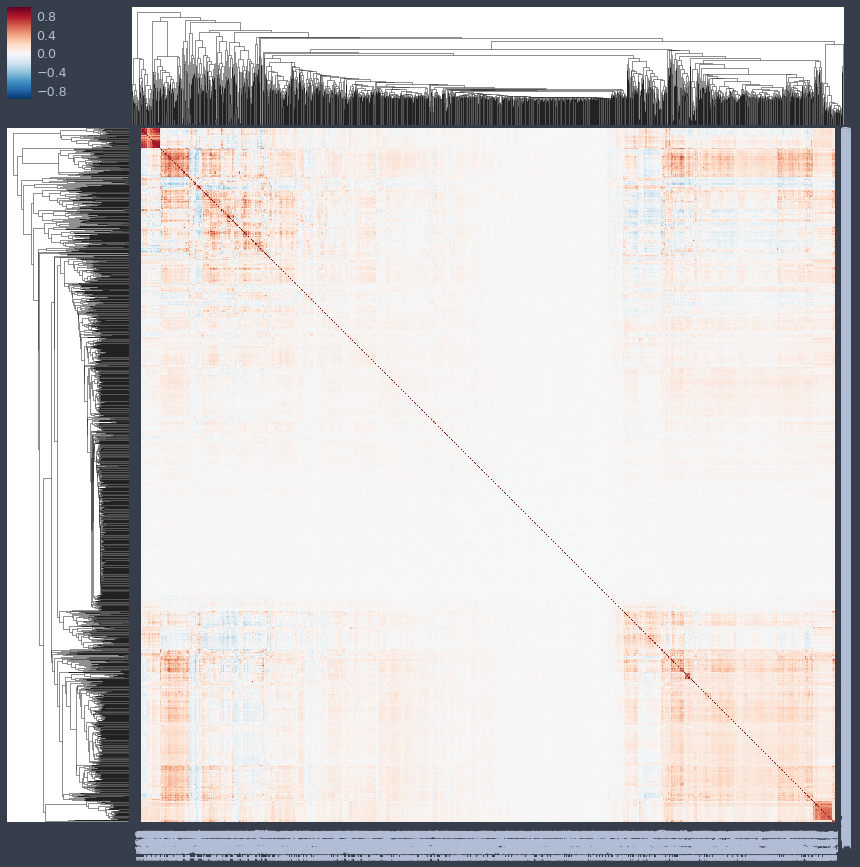

In [5]:
## Make the correlation matrix
X_corrs = pd.DataFrame(X_scl).corr(method = 'spearman')
X_corrs = X_corrs.dropna(how = 'all', axis = 1).dropna(how = 'all', axis = 0)
# Make a heatmap of the correlations
sns.clustermap(X_corrs, square=True, linewidths = 0, figsize = [15, 15])

### We can see that a significant proportion of the miRNAs form groups of similarity/dissimilarity. This is good because it suggests we can pare down the dataset to exclude genes with similar behavior to accomplish aim 2.

### Let's look at the mRNA data

In [7]:
print('Importing data...')
## Import X and y data for micro RNAs
X_vals, X_feats, X_samps, y = getData('../data/new_mrna_X.csv', '../data/new_mrna_y.csv', [])
print('Done!')

Importing data...
Done!


### There are many null values as is common with large molecular datasets

In [8]:
X_vals[np.isnan(X_vals)] = 0
print(np.array([X_vals.shape[0]]*X_vals.shape[1]) - np.count_nonzero(X_vals, axis = 0))

[ 5511  5168     0 ..., 10995     1 10217]


### Let's find the effective dimensionality of the data.

Scaling data...
Getting principle components...
Explained variances of top components: [ 0.09595419  0.03930294  0.02589748  0.02521353  0.02251958  0.01856953
  0.01478733  0.01165917  0.01125527  0.01006074  0.00874899  0.00816022
  0.00791149  0.00741948  0.0068346   0.00674327  0.00653548  0.00610375
  0.00583859  0.00565222]
76 components explain the majority of the variance.


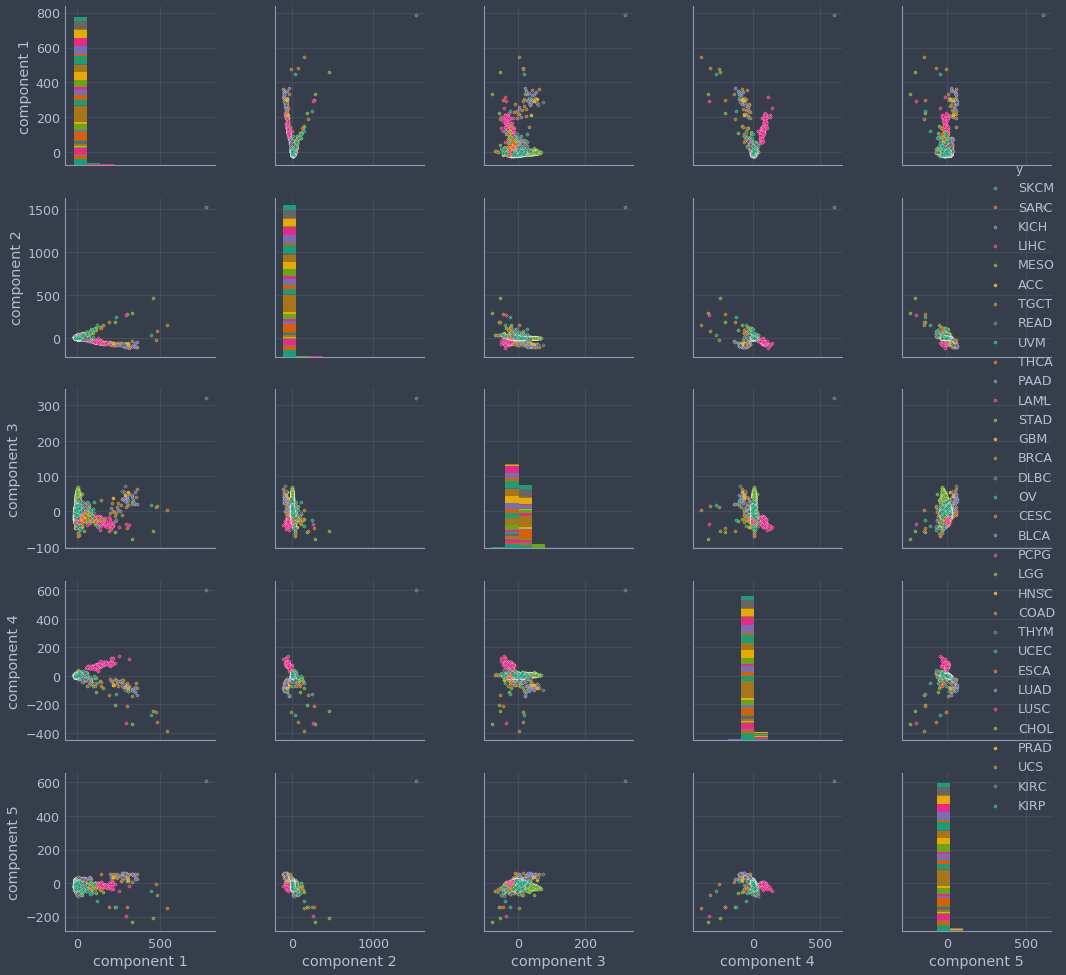

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

print('Scaling data...')
# scl = StandardScaler()
# X_scl = scl.fit_transform(X_vals, y)

# del X_vals
# gc.collect()

print('Getting principle components...')
n_components = 1000
n_feats = 10000
## The dataset is too big for in-memory PCA, so we'll randomly choose a subset of features
feat_inds = np.random.choice(range(X_scl.shape[1]), n_feats, replace = False)
pca = PCA(n_components = n_components)
X_pca = pca.fit_transform(X_scl[:,feat_inds], y)

## Explained variance for each component
print('Explained variances of top components:', pca.explained_variance_ratio_[:20])
sum_of_explained_variance = 0
n_components_needed_for_majority_variance = 0
for i, each in enumerate(pca.explained_variance_ratio_):
    sum_of_explained_variance += each
    if sum_of_explained_variance > 0.5:
        n_components_needed_for_majority_variance = i+1
        break
if n_components_needed_for_majority_variance > 0:
    print(n_components_needed_for_majority_variance, 'components explain the majority of the variance.')
else:
    print('100 components could only explain', sum_of_explained_variance*100, 'percent of the variance.')
## Make plots of decomposed and transformed data
sns.pairplot(pd.concat([pd.DataFrame(X_pca[:,0:5], index = X_samps, 
                                     columns = ['component 1', 'component 2', 'component 3', 'component 4', 'component 5']), 
                        y], axis = 1), hue = y.y.name, size = 2.75, plot_kws={'s':10}, palette = 'Dark2')

### The dataset has a high effective dimensionality with the top 76 principal components accounting for the majority of the variance.

### Let's look at how the messenger RNAs correlate with each other

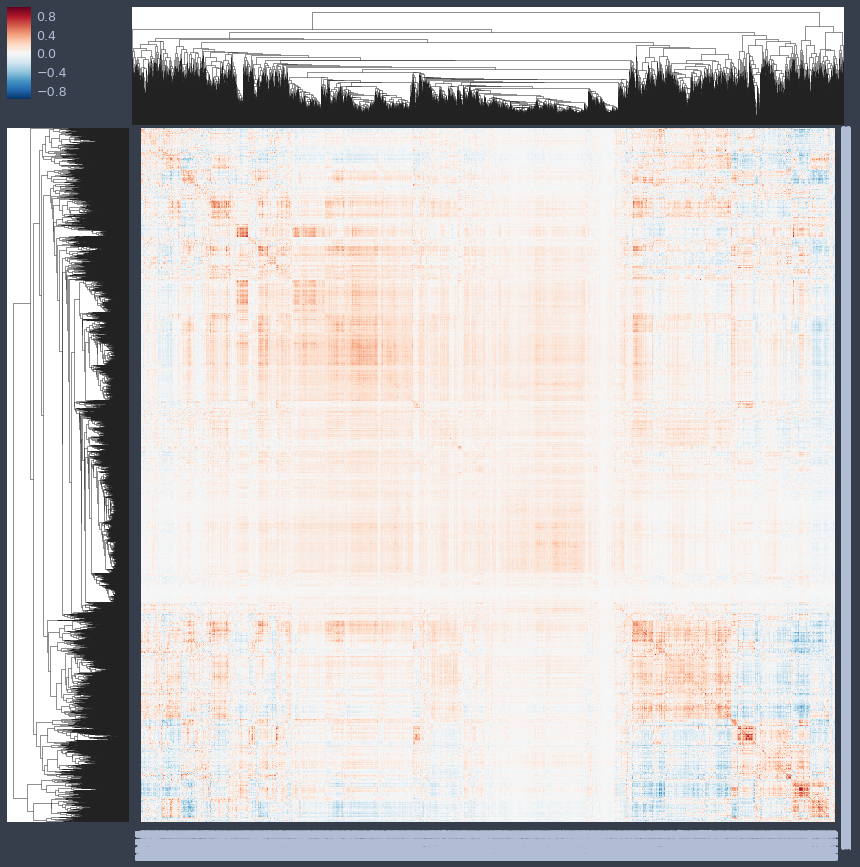

In [12]:
## Make the correlation matrix
X_corrs = pd.DataFrame(X_scl[:,feat_inds]).corr(method = 'spearman')
X_corrs = X_corrs.dropna(how = 'all', axis = 1).dropna(how = 'all', axis = 0)
# Make a heatmap of the correlations
sns.clustermap(X_corrs, square=True, linewidths = 0, figsize = [15, 15])